In [1]:
# Standard libraries
import sys
import math
import random
import time
import os

# Third-party imports
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import keras_tuner as kt

import importlib
from yapf.yapflib.yapf_api import FormatCode
import GPUtil

# Project imports
import ephesus
import utils
from const import *

#### GPU Setup

In [2]:
# Specific GPUs
desir_gpus = [1]
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices([gpus[i] for i in desir_gpus], 'GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
mirro_strat = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


#### Data Preprocessing

In [3]:
# Find the most recent file in injec_curve
datas = utils.retur_most_recen(f'{xom_data_path}padde_cuts/')
# datas = 'padde_cuts-34745-2850-6998.pkl'
print(f'Most recent file: {datas}')

with open(f'{xom_data_path}padde_cuts/{datas}','rb') as f:
    raw_x_data = pkl.load(f)

Most recent file: combi-padde_cuts-345235-30352-72662.pkl


KeyboardInterrupt: 

In [ ]:
# Dataset composition setup
DETEC_TYPE = 'plane_moon_cut_injec'
NUMBE_RELEV = 5000
NUMBE_IRREL = 5000

In [ ]:
# Separate full dataset into relevant and irrelevant components
full_relev_index = []
for i in range(len(raw_x_data)):
    if raw_x_data[i, -1, 1][DETEC_TYPE]:
        full_relev_index.append(i)
        
# Take a random sample of a relevant
relev_index = random.sample(full_relev_index, NUMBE_RELEV)
relev_curve = np.copy(raw_x_data[relev_index])
# Take a random sample of a irrelevant
irrel_curve = np.delete(raw_x_data, full_relev_index, axis=0)
irrel_curve = irrel_curve[utils.retur_rando_sampl(NUMBE_IRREL, len(irrel_curve))]

# Shuffle the order of the data
rando_shuff_x_data = np.concatenate((relev_curve, irrel_curve), axis=0)
np.random.shuffle(rando_shuff_x_data)

# Normalize the data from 0 to 1
norma_full_x_data = np.copy(rando_shuff_x_data)
x_data = np.copy(rando_shuff_x_data[:, :-1, 1].astype(float))

for i in range(len(x_data)):
    chang_slots = np.where(x_data[i] != 0)[0]
    x_data[i, chang_slots] = utils.norma_data(x_data[i, chang_slots])
    norma_full_x_data[i, :-1, 1] = x_data[i]

x_data = np.expand_dims(x_data, 2)

# Create the corresponding y dataset
y_data = np.zeros(len(norma_full_x_data))
for i in range(len(norma_full_x_data)):
    y_data[i] = norma_full_x_data[i, -1, 1][DETEC_TYPE]

print(
    f'{sum(y_data)/len(y_data):.2%} of the dataset contains a full injection')

In [ ]:
# Split the data into training and testing

stop = len(x_data) - len(y_data) % 100
split = int(stop * 0.7)
    
x_train = np.array(x_data[:split])
full_x_train = norma_full_x_data[:split]
x_test = np.array(x_data[split:stop])
full_x_test = norma_full_x_data[split:stop]
y_train = y_data[:split]
y_test = y_data[split:stop]

In [ ]:
# Remove non-full batches (because they cause problems)
BATCH_SIZE = 100

# If no remainder, skip
if x_train.shape[0] % BATCH_SIZE:
    x_train = x_train[:-(x_train.shape[0] % BATCH_SIZE)]
    full_x_train = full_x_train[:-(full_x_train.shape[0] % BATCH_SIZE)]
    y_train = y_train[:-(y_train.shape[0] % BATCH_SIZE)]

if x_test.shape[0] % BATCH_SIZE:
    x_test = x_test[:-(x_test.shape[0] % BATCH_SIZE)]
    full_x_test = full_x_test[:-(full_x_test.shape[0] % BATCH_SIZE)]
    y_test = y_test[:-(y_test.shape[0] % BATCH_SIZE)]

#### Tuner Opening

#### Model Redundancy

In [ ]:
dependencies = {
    'preci': utils.preci,
    'recal':utils.recal
}

In [9]:
# xom/moon/keras_tuner/12-05-2022_22:55:42_kt/redun_model/t:10_va:0.545.h5
model_file = f'{xom_data_path}keras_tuner/14-05-2022_16:53:21_kt/redun_model/t:14_va:0.552.h5'
model = tf.keras.models.load_model(model_file,custom_objects=dependencies);

## Testing

In [10]:
start = 0
stop = None

x_full_predi_data = full_x_test[start:stop]
x_predi_data = x_test[start:stop]
y_predi_data = y_test[start:stop]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 1900, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1900, 250)         252000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               519168    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0

In [12]:
# Make predictions
predi = model.predict(x_predi_data).squeeze()

In [24]:
sum(predi > 0.54)

2041

In [13]:
cutof = 0.5

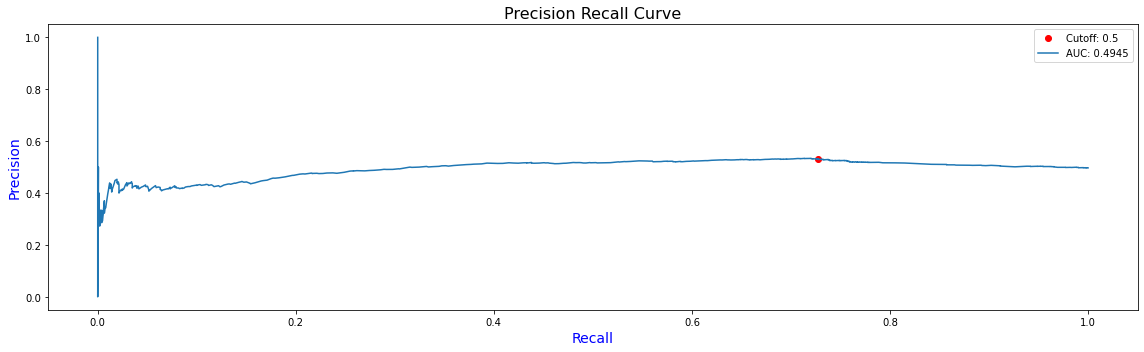

In [14]:
utils.show_preci_recal(predi, y_predi_data, cutof)

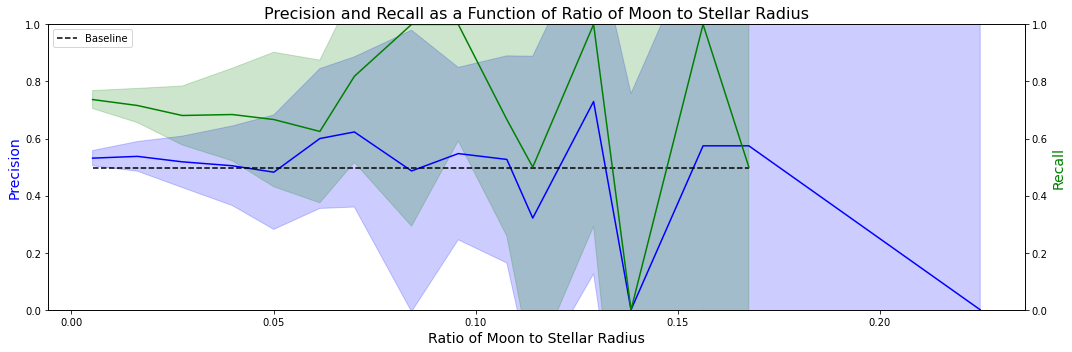

In [25]:
utils.show_featu_preci_recal(x_full_predi_data, predi, y_predi_data, cutof, 'ratio_moon_stell_radiu')

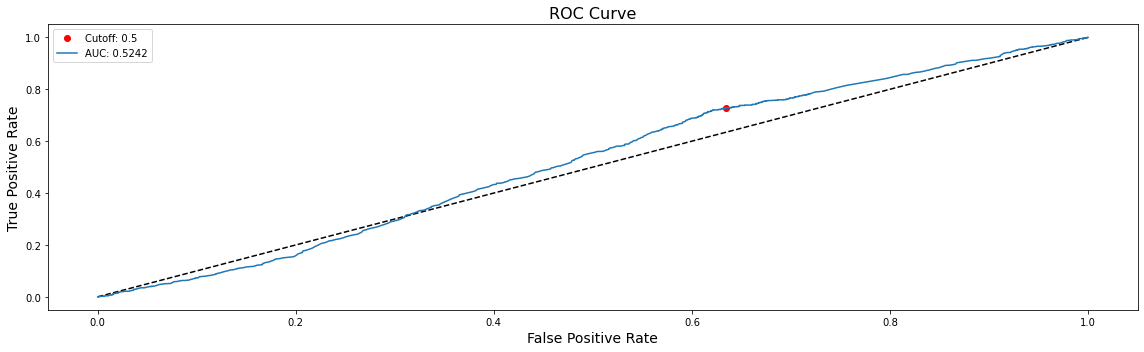

In [16]:
utils.show_roc(predi, y_predi_data, cutof)

In [17]:
type(x_predi_data)

numpy.ndarray

In [18]:
def get_saliency_map(model, image, class_idx):
    if isinstance(image, np.ndarray):
        image = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)

        loss = predictions[:, class_idx]
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    smap = gradient
    # normaliz between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
    
    return smap

In [19]:
salie_predi = get_saliency_map(model, x_predi_data, 0)

ResourceExhaustedError: OOM when allocating tensor with shape[3000,250] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Tanh]

In [ ]:
num = 0

In [ ]:
x_full_predi_data[num, -1, 1][DETEC_TYPE]

In [ ]:
utils.show_curve(x_full_predi_data, [num,num+1], highl_injec=1)

In [ ]:
plt.figure(figsize=(20,5))
# print(np.where(a[num]<.99999)[0])
data = a[num]#[np.where(a[num]<.99999)]
# data = a[num]
plt.plot(data)

#### Formatting